# LoRa

## Overview

What is LORA?

- (Lo)ng (Ra)nge, low power, RF modulation technology for low-power wide-area networks (LPWANs).
- Created by Semtech

### Range

- 3 [mi] || 5 [km] (urban)
- 10 [mi] || 15 [km] (line of sight)

### Technology

Proprietary spread-spectrum modulation based on Chirp Spread Spectrum technology.

- Uses orthoganal spreading factors

- Distance directly ties in to spreading factor as that is the primary link budget consideration.
    - Close distance == lower spreading factor (since small link budget needed)
    - Further distance == higher spreading factor (increased processing gain, higher reception sensitivity, lower data rate)

- Where does it sit within the OSI Model?
    - ![#osi_model](notes/images/osi_model.png)

#### Parameters

- Bandwidth [bw]: 125, 250, or 500 [kHz]
- Spreading Factor [sf]: 7-12 [bits/symbol]
- Number of symbols [symbol_rate]: 2^sf 
- Chirp Rate [cr]: bw/symbol_rate

#### Bandwidth

- Uplink
    - 125 [kHz]
    - 500 [kHz]
- Downlink
    - 500 [kHz]

#### Frame

![#frame](notes/images/frame.png)

- First 8 symbols:
    - Spreading Factor of header is: sf-2
        - regardless of explicit/implicit mode
    - Coding Rate of header is always: 4/8

### References

[Semtech](https://www.semtech.com/uploads/technology/LoRa/lora-and-lorawan.pdf#page=3.99)
[MobileFish](https://lora.readthedocs.io/en/latest/)
[Decoding Lora](https://media.ccc.de/v/33c3-7945-decoding_the_lora_phy#t=1848)

## Load Config

In [1]:
# Extract configuration from yaml
import yaml

with open("config.yaml") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

print(cfg)
sf = cfg.get('spreading_factor')
bw = cfg.get('bandwidth')
Fs = bw  # Matching sample rate to bandwidth
Fc = cfg.get('carrier_frequency')
explicit_header = cfg.get('explicit_header')

{'spreading_factor': 8, 'bandwidth': 500000.0, 'explicit_header': True, 'carrier_frequency': 40000000.0}


## Convert Transmission Message to Binary

In [2]:
with open("message.txt") as f:
    input_message = f.read()
    encoding = 'utf-8'
    binary_message = bytes(input_message, encoding)
print(binary_message)
# As Bytes
print("\n".join(format(byte, "08b") for byte in binary_message))

b'Hello, Nick!'
01001000
01100101
01101100
01101100
01101111
00101100
00100000
01001110
01101001
01100011
01101011
00100001


## Packet Formation
### Gray Indexing


### Whitening 

XOR w/ pseudo-random seq

- mitigates the effects of long sequences of identical bit
- better RX clock recovery

LFSR (linear feedback shift register)

XOR Operation

### Interleaving

### Hamming FEC

Hamming(#databits + #paritybits, #databits) i.e. Hamming(8,4)

Hamming(5,4) and (6,4) provide error detection as a
parity bit would, whereas (7,4) and (8,4) provide single bit
correction with (8,4) additionally providing dual error detection.

|-- Preamble --|-- Sync Word --|-- Header --|-- Payload --|-- CRC (optional) --|

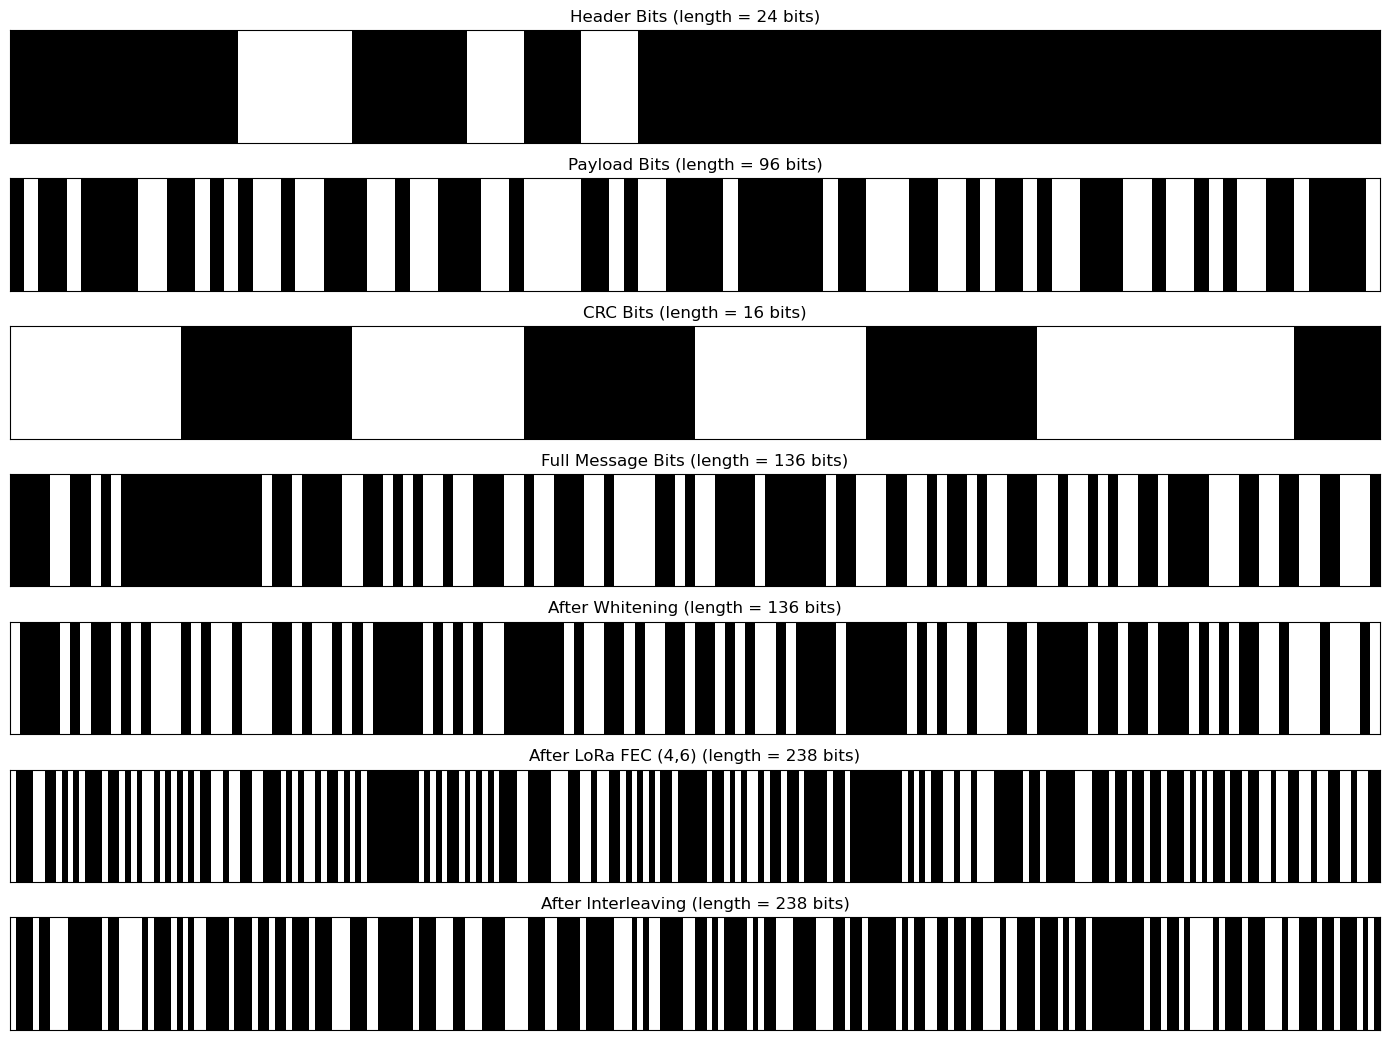

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# -------------------------------------
# Utility Functions for Bit Manipulation
# -------------------------------------

def bytes_to_bits(byte_array: List[int]) -> List[int]:
    return [int(bit) for byte in byte_array for bit in f'{byte:08b}']

def bits_to_bytes(bits: List[int]) -> List[int]:
    return [int("".join(map(str, bits[i:i+8])), 2) for i in range(0, len(bits), 8)]

# -------------------------------------
# Whitening via LFSR (Linear Feedback Shift Register)
# -------------------------------------

def lfsr_whitening(bits: List[int], seed=0x01, taps=(6, 3)) -> List[int]:
    lfsr = seed & 0x7F
    whitened = []
    for bit in bits:
        whitened_bit = bit ^ (lfsr & 1)
        whitened.append(whitened_bit)
        new_bit = sum([(lfsr >> t) & 1 for t in taps]) % 2
        lfsr = ((lfsr << 1) | new_bit) & 0x7F
    return whitened

# -------------------------------------
# LoRa-Compatible FEC Encoder (4 -> 4+CR)
# -------------------------------------

def lora_fec_encode(bits: List[int], cr: int) -> List[int]:
    if not 1 <= cr <= 4:
        raise ValueError("CR must be between 1 and 4")

    G = np.array([
        [1, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 1]
    ])
    encoded = []
    for i in range(0, len(bits), 4):
        d = np.array([bits[i + j] if i + j < len(bits) else 0 for j in range(4)])
        c = (d @ G) % 2
        padded = np.concatenate([c, np.zeros(cr - 1, dtype=int)])  # padding for CR
        encoded.extend(padded.tolist())
    return encoded


# -------------------------------------
# LoRa-Style Diagonal Interleaving
# -------------------------------------

def diagonal_interleave(bits: List[int], sf: int) -> List[int]:
    ncol = sf + 2
    nrow = int(np.ceil(len(bits) / ncol))
    matrix = np.zeros((nrow, ncol), dtype=int)
    for i, bit in enumerate(bits):
        r, c = divmod(i, ncol)
        matrix[r, c] = bit
    interleaved = []
    for col in range(ncol):
        for row in range(nrow):
            c = (col + row) % ncol
            interleaved.append(matrix[row, c])
    return interleaved[:len(bits)]

# -------------------------------------
# Gray Code Symbol Mapping
# -------------------------------------

def binary_to_gray(bits: List[int], sf: int) -> List[int]:
    gray_syms = []
    for i in range(0, len(bits), sf):
        val = sum(bits[i + j] << j for j in range(min(sf, len(bits) - i)))
        gray_val = val ^ (val >> 1)
        gray_syms.append(gray_val)
    return gray_syms

# -------------------------------------
# CRC-16-CCITT Checksum (Used in LoRaWAN)
# -------------------------------------

def crc16_ccitt(data_bytes: List[int]) -> bytes:
    crc = 0xFFFF
    for b in data_bytes:
        crc ^= b << 8
        for _ in range(8):
            crc = ((crc << 1) ^ 0x1021) if (crc & 0x8000) else (crc << 1)
            crc &= 0xFFFF
    return crc.to_bytes(2, byteorder='big')

# -------------------------------------
# Bitstream Visualization
# -------------------------------------

def plot_bit_stages(stages: List[List[int]], titles: List[str]):
    fig, axs = plt.subplots(len(stages), 1, figsize=(14, len(stages) * 1.5))
    for i, (stage, title) in enumerate(zip(stages, titles)):
        axs[i].imshow(np.array(stage).reshape(1, -1), cmap='gray', aspect='auto')
        axs[i].set_title(f"{title} (length = {len(stage)} bits)")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.tight_layout()
    plt.show()

# -------------------------------------
# Packet Formation
# -------------------------------------

def prepare_lora_message(
    binary_message: List[int],
    sf: int,
    explicit_header: bool,
    cr: int = 1,
    cr_enabled: bool = True,
) -> Tuple[List[int], List[int]]:
    header_bytes = []
    payload_bytes = list(binary_message)

    if explicit_header:
        length = len(payload_bytes)
        flags = 0
        if cr_enabled:
            flags |= (1 << 7)  # Enable CRC
        flags |= ((cr - 1) & 0b11) << 5  # Embed CR into flags
        reserved = 0x00
        header_bytes = [length, flags, reserved]

    crc_bytes = list(crc16_ccitt(payload_bytes))
    full_bytes = header_bytes + payload_bytes + crc_bytes
    bits = bytes_to_bits(full_bytes)
    whitened = lfsr_whitening(bits)
    fec_encoded = lora_fec_encode(whitened, cr=cr)
    
    header_bit_len = len(bytes_to_bits(header_bytes)) if explicit_header else 0
    split_index = int(len(fec_encoded) * header_bit_len / len(bits)) if explicit_header else 0

    if explicit_header:
        header_bits = fec_encoded[:split_index]
        payload_bits = fec_encoded[split_index:]
        header_interleaved = diagonal_interleave(header_bits, sf=sf-2)
        payload_interleaved = diagonal_interleave(payload_bits, sf=sf)
        header_syms = binary_to_gray(header_interleaved, sf=sf-2)
        payload_syms = binary_to_gray(payload_interleaved, sf=sf)
        plot_bit_stages([
            bytes_to_bits(header_bytes),
            bytes_to_bits(payload_bytes),
            bytes_to_bits(crc_bytes),
            bits,
            whitened,
            fec_encoded,
            header_interleaved + payload_interleaved
        ], [
            "Header Bits",
            "Payload Bits",
            "CRC Bits",
            "Full Message Bits",
            "After Whitening",
            f"After LoRa FEC (4,{4+cr})",
            "After Interleaving"
        ])
        return header_syms, payload_syms
    else:
        interleaved = diagonal_interleave(fec_encoded, sf=sf)
        payload_syms = binary_to_gray(interleaved, sf=sf)
        return [], payload_syms


# Apply logic from YAML config
header_syms, payload_syms = prepare_lora_message(binary_message, sf, explicit_header, cr=2)

## Modulation

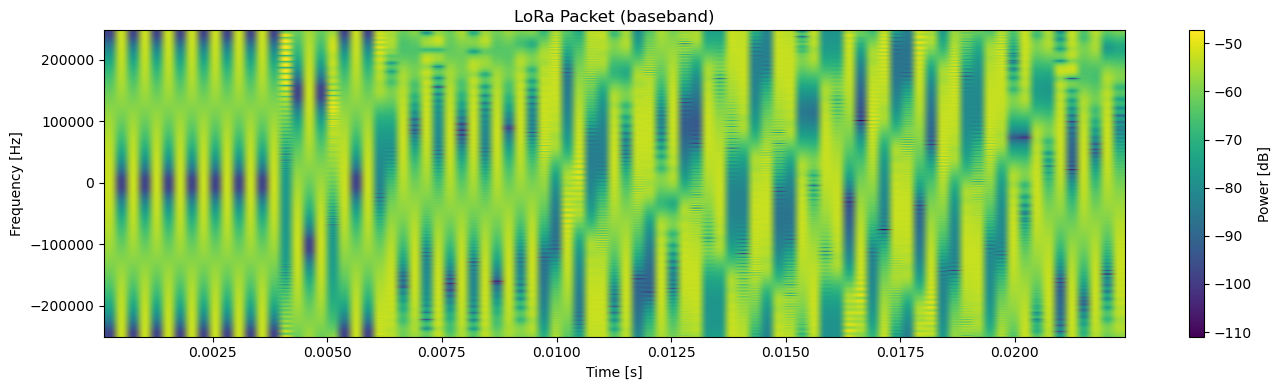

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# -------------------------------------
# Chirp Signal Generation (centered at 0 Hz: -BW/2 to BW/2)
# -------------------------------------


def generate_chirp(sf: int, bw: float, Fs: float, up=True) -> np.ndarray:
    M = 2 ** sf
    T = M / bw
    t = np.linspace(0, T, int(Fs * T), endpoint=False)
    k = bw / T
    f_start = -bw / 2
    phase = 2 * np.pi * (f_start * t + 0.5 * k * t**2)
    if not up:
        phase *= -1
    return np.exp(1j * phase)

# -------------------------------------
# Symbol Modulation
# -------------------------------------

def modulate_symbols(symbols: List[int], sf: int, bw: float, Fs: float) -> np.ndarray:
    M = 2 ** sf
    base_chirp = generate_chirp(sf, bw, Fs, up=True)
    Ns = len(base_chirp)
    return np.concatenate([
        np.roll(base_chirp, int((s % M) * Ns / M)) for s in symbols
    ])

def modulate_sync_word(sync_word: int, sf: int, bw: float, Fs: float) -> np.ndarray:
    base = generate_chirp(sf, bw, Fs, up=True)
    # For LoRaWAN, sync_word is a fixed value (e.g., 0x12 or 0x34)
    # Here, we use the sync_word as a fraction of the symbol length
    offset = int((sync_word % 256) * len(base) / 256)
    return np.concatenate([np.roll(base, offset)] * 2)

# -------------------------------------
# Packet Generation
# -------------------------------------

def generate_lora_packet_with_header(
    header_syms: List[int],
    payload_syms: List[int],
    sf: int,
    bw: float,
    Fs: float,
    sync_word: int = 0x34,  # Or 0x12 for LoRaWAN
    preamble_len: int = 8
) -> np.ndarray:
    upchirp = generate_chirp(sf, bw, Fs, up=True)
    downchirp = generate_chirp(sf, bw, Fs, up=False)
    Ns = len(upchirp)

    preamble = np.tile(upchirp, preamble_len)
    sync = modulate_sync_word(sync_word, sf, bw, Fs)
    sfd = np.concatenate([downchirp, downchirp, downchirp[:Ns // 4]])

    # Use same SF for header and payload for LoRaWAN
    header_mod = modulate_symbols(header_syms, sf, bw, Fs) if header_syms else np.array([], dtype=np.complex64)
    payload_mod = modulate_symbols(payload_syms, sf, bw, Fs)

    return np.concatenate([preamble, sync, sfd, header_mod, payload_mod])

# -------------------------------------
# Spectrogram Display
# -------------------------------------

def plot_spectrogram(signal: np.ndarray, Fs: float, title: str = ""):
    plt.figure(figsize=(14, 4))
    plt.specgram(signal, NFFT=256, Fs=Fs, noverlap=128, scale='dB', mode='psd')
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="Power [dB]")
    plt.tight_layout()
    plt.show()

# Generate baseband_signal and plot
baseband_signal = generate_lora_packet_with_header(header_syms, payload_syms, sf, bw, Fs)
plot_spectrogram(baseband_signal, Fs, title="LoRa Packet (baseband)")

## Transmission

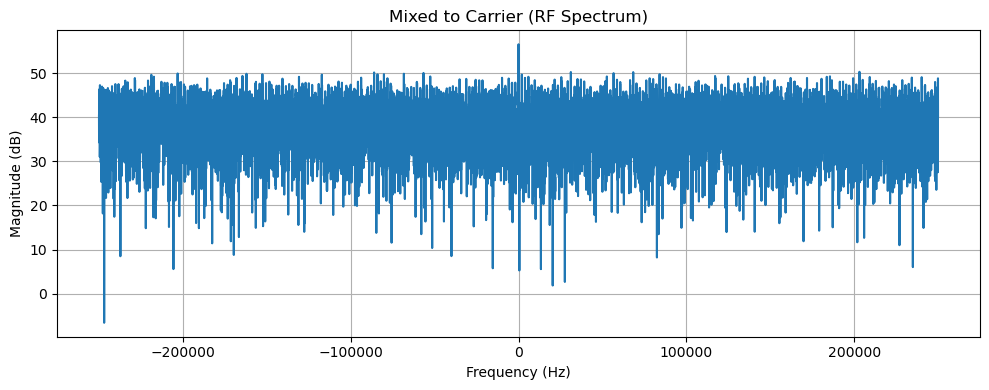

In [9]:
def mix_to_carrier(iq: np.ndarray, Fc: float, Fs: float) -> np.ndarray:
    t = np.arange(len(iq)) / Fs
    carrier = np.exp(2j * np.pi * Fc * t)
    return iq * carrier / np.max(np.abs(iq * carrier))  # optional normalization

def plot_spectrum(signal, Fs, title=""):
    freqs = np.fft.fftfreq(len(signal), d=1/Fs)
    spectrum = 20 * np.log10(np.abs(np.fft.fft(signal)) + 1e-12)
    plt.figure(figsize=(10, 4))
    plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(spectrum))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

rf_signal = mix_to_carrier(baseband_signal, Fc, Fs)
plot_spectrum(rf_signal, Fs, title="Mixed to Carrier (RF Spectrum)")

## Demodulation & Packet Retrieval

Correlation peak at index: 5539


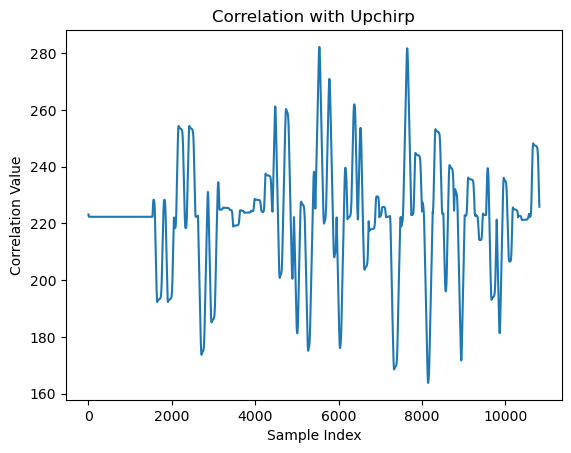

🔍 Correlation peak at index: 5539 (max corr: 282.29)
⚠️ Start index not aligned to symbol boundary, offset: 419
🔍 Symbol-aligned start detected at index: 5632
Trimmed signal length: 5696 samples
Total symbols after trimming: 11
Symbols to skip: 12
Symbol length: 512
❌ Not enough symbols after trimming


In [11]:
import numpy as np
from scipy.signal import butter, lfilter, correlate
from numpy.fft import fft
import matplotlib.pyplot as plt
from typing import List, Optional

# ------------------ Configuration ------------------
# Set these before calling the main function
# bw = 125e3
# sf = 7
# Fc = 868e6
cr = 2
demod_fs = 2 * bw
symbol_len = int(demod_fs * (2**sf) / bw)
total_skip = 8 + 2 + 2  # preamble + sync + sfd (adjust as needed)

# ------------------ Helper Functions ------------------

def butter_lowpass_filter(data, cutoff, Fs, order=5):
    nyq = 0.5 * Fs
    norm_cutoff = min(cutoff / nyq, 0.99)
    b, a = butter(order, norm_cutoff, btype='low')
    return lfilter(b, a, data)

def generate_chirp(sf, bw, Fs, up=True):
    Ts = (2**sf) / bw
    t = np.linspace(0, Ts, int(Fs * Ts), endpoint=False)
    k = bw / Ts
    phase = 2 * np.pi * (0.5 * k * t ** 2)
    return np.exp(1j * phase) if up else np.exp(-1j * phase)

def gray_to_binary(gray: int) -> int:
    binary = gray
    shift = gray >> 1
    while shift:
        binary ^= shift
        shift >>= 1
    return binary

def reverse_diagonal_interleave(bits: List[int], sf: int) -> List[int]:
    ncol = sf + 2
    nrow = int(np.ceil(len(bits) / ncol))
    matrix = np.zeros((nrow, ncol), dtype=int)
    idx = 0
    for col in range(ncol):
        for row in range(nrow):
            if idx >= len(bits): break
            c = (col + row) % ncol
            matrix[row, c] = bits[idx]
            idx += 1
    return list(matrix.flatten())[:len(bits)]

def lora_fec_decode(bits: List[int], cr: int) -> List[int]:
    """
    Decode LoRa FEC (4,4+CR) code. This is a simplified decoder for demonstration.
    For a full (4,4+CR) decoder, you may need to implement a proper syndrome decoder.
    Here, we use a simple (4,6) code with parity check as in your modulator.
    """
    n = 6 + (cr - 1)
    decoded = []
    H = np.array([
        [1, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0, 1]
    ])
    for i in range(0, len(bits), n):
        codeword = np.array([bits[i + j] if (i + j) < len(bits) else 0 for j in range(6)])
        s = (H @ codeword[:6]) % 2
        syndrome = int(f"{s[0]}{s[1]}", 2)
        if 0 < syndrome <= 6:
            codeword[syndrome - 1] ^= 1
        decoded.extend(codeword[:4])
    return decoded

def lfsr_whitening(bits: List[int], seed=0x01, taps=(6, 3), length=None) -> List[int]:
    """
    Whitening using LFSR with same seed and taps as modulator.
    """
    lfsr = seed & 0x7F
    whitened = []
    for i, bit in enumerate(bits):
        if length is not None and i >= length:
            break
        whitened_bit = bit ^ (lfsr & 1)
        whitened.append(whitened_bit)
        new_bit = sum([(lfsr >> t) & 1 for t in taps]) % 2
        lfsr = ((lfsr << 1) | new_bit) & 0x7F
    return whitened

def bits_to_bytes(bits: List[int]) -> bytes:
    padded = bits + [0] * ((8 - len(bits) % 8) % 8)
    return bytes([int("".join(map(str, padded[i:i+8])), 2) for i in range(0, len(padded), 8)])

def crc16_lora(data: bytes) -> int:
    crc = 0x0000
    poly = 0x1021
    for byte in data:
        crc ^= (byte << 8)
        for _ in range(8):
            crc = ((crc << 1) ^ poly) & 0xFFFF if (crc & 0x8000) else (crc << 1) & 0xFFFF
    return crc

def plot_bin_values(bin_syms: List[int], title: str = "Binary Symbol Indices (Payload Only)"):
    plt.figure(figsize=(10, 3))
    plt.stem(bin_syms, basefmt=" ")
    plt.title(title)
    plt.xlabel("Symbol #")
    plt.ylabel("Bin Value")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# ------------------ Main Demodulation Function ------------------

def demodulate_lora_packet(
    rf_signal: np.ndarray,
    sf: int,
    bw: float,
    Fc: float,
    cr: int,
    total_skip: int = 8 + 2 + 2,
    plot_bins: bool = True,
    threshold: float = 0.7,
    align_to_symbol: bool = True,
    whitening_seed: int = 0x01,
    whitening_taps: Tuple[int, int] = (6, 3),
) -> Tuple[Optional[str], int, int, int, int]:
    """
    Demodulate a LoRa packet from RF signal.

    Args:
        rf_signal: Received RF signal (complex baseband after mixing to carrier)
        sf: Spreading factor
        bw: Bandwidth
        Fc: Carrier frequency (for downconversion, not used if already baseband)
        cr: Code rate (1-4)
        total_skip: Number of symbols to skip (preamble + sync + sfd)
        plot_bins: Plot payload symbol indices
        threshold: Correlation threshold (fraction of max correlation)
        align_to_symbol: Align start index to symbol boundary
        whitening_seed: LFSR seed for whitening (must match modulator)
        whitening_taps: LFSR taps for whitening (must match modulator)

    Returns:
        tuple: (recovered_str, total_rf_samples, Ns, trimmed_len, num_payload_syms)
    """
    demod_fs = 2 * bw
    symbol_len = int(demod_fs * (2**sf) / bw)

    # Step 1: Downconvert and filter
    t = np.arange(len(rf_signal)) / demod_fs
    downconverted = rf_signal * np.exp(-1j * 2 * np.pi * Fc * t)
    filtered = butter_lowpass_filter(downconverted, cutoff=0.6 * bw, Fs=demod_fs)
    recovered_baseband = filtered / np.max(np.abs(filtered))

    # Step 2: Detect start using correlation with upchirp
    ref_upchirp = generate_chirp(sf, bw, demod_fs, up=True)
    corr = correlate(np.abs(recovered_baseband), np.abs(ref_upchirp), mode='valid')
    start_idx = np.argmax(corr)
    print(f"Correlation peak at index: {start_idx}")
    plt.plot(corr)
    plt.title("Correlation with Upchirp")
    plt.xlabel("Sample Index")
    plt.ylabel("Correlation Value")
    plt.show()

    max_corr = np.max(corr)
    if max_corr < threshold * np.max(corr):
        print("⚠️ No valid correlation peak found")
        return "<no valid peak>", len(rf_signal), symbol_len, 0, 0
    start_idx = np.argmax(corr)
    print(f"🔍 Correlation peak at index: {start_idx} (max corr: {max_corr:.2f})")

    # Optional: Align to the next symbol boundary
    if align_to_symbol:
        start_offset = start_idx % symbol_len
        if start_offset != 0:
            print(f"⚠️ Start index not aligned to symbol boundary, offset: {start_offset}")
            start_idx += (symbol_len - start_offset)
            if start_idx >= len(recovered_baseband):
                print("⚠️ Cannot align to symbol boundary: signal too short")
                return "<alignment failed>", len(rf_signal), symbol_len, 0, 0
    print(f"🔍 Symbol-aligned start detected at index: {start_idx}")

    # Trim the signal to start at the detected peak
    trimmed = recovered_baseband[start_idx:]
    print(f"Trimmed signal length: {len(trimmed)} samples")

    # Step 3: Symbol slicing
    rx_syms = np.array_split(trimmed[:len(trimmed) // symbol_len * symbol_len], len(trimmed) // symbol_len)
    print(f"Total symbols after trimming: {len(rx_syms)}")
    print(f"Symbols to skip: {total_skip}")
    print(f"Symbol length: {symbol_len}")

    # Step 4: Skip preamble, sync word, and sync symbols
    if len(rx_syms) <= total_skip:
        print("❌ Not enough symbols after trimming")
        return "<not enough symbols>", len(rf_signal), symbol_len, len(trimmed), 0
    payload_syms = rx_syms[total_skip:]

    # Step 5: Dechirp and FFT for payload only
    dechirped = [sym * np.conj(ref_upchirp) for sym in payload_syms]
    symbol_bins = [np.argmax(np.abs(fft(d))) % (2**sf) for d in dechirped]
    bin_syms = [gray_to_binary(sym) for sym in symbol_bins]
    if plot_bins:
        plot_bin_values(bin_syms)

    # Step 6: Packet analysis
    if len(bin_syms) < 1:
        print("❌ No payload symbols detected")
        return "<no payload>", len(rf_signal), symbol_len, len(trimmed), len(payload_syms)

    # Unpack to bits (note: this may need adjustment for SF > 8)
    bitstream = np.concatenate([np.unpackbits(np.array([b], dtype=np.uint8)) for b in bin_syms]).astype(int)
    deinterleaved = reverse_diagonal_interleave(bitstream.tolist(), sf)
    decoded_bits = lora_fec_decode(deinterleaved, cr=cr)
    dewhitened = lfsr_whitening(decoded_bits, seed=whitening_seed, taps=whitening_taps)

    if len(dewhitened) < 32:
        print("❌ Not enough bits for LoRa header")
        return "<no header>", len(rf_signal), symbol_len, len(trimmed), len(payload_syms)

    header_bits = dewhitened[:32]
    header = bits_to_bytes(header_bits)
    payload_len = header[0]
    cr_header = (header[1] >> 5) & 0x03
    crc_enabled = (header[1] >> 4) & 0x01
    print(f"📦 Header → Len: {payload_len} bytes, CR: {cr_header + 1}, CRC: {bool(crc_enabled)}")

    expected_payload_bits = payload_len * 8
    expected_crc_bits = 16 if crc_enabled else 0
    total_needed = 32 + expected_payload_bits + expected_crc_bits

    if len(dewhitened) < total_needed:
        print(f"⚠️ Not enough bits: required {total_needed}, got {len(dewhitened)}")
        return "<incomplete>", len(rf_signal), symbol_len, len(trimmed), len(payload_syms)
    else:
        payload_bits = dewhitened[32:32 + expected_payload_bits]
        payload_bytes = bits_to_bytes(payload_bits)
        if crc_enabled:
            crc_start = 32 + expected_payload_bits
            crc_bits = dewhitened[crc_start:crc_start + 16]
            crc_bytes = bits_to_bytes(crc_bits)
            received_crc = int.from_bytes(crc_bytes, byteorder='little')
            computed_crc = crc16_lora(payload_bytes)
            print(f"🔎 CRC → Computed: 0x{computed_crc:04X}, Received: 0x{received_crc:04X}")
            if computed_crc != received_crc:
                print("❌ CRC mismatch")
                return "<crc error>", len(rf_signal), symbol_len, len(trimmed), len(payload_syms)
            else:
                recovered_str = ''.join(chr(b) for b in payload_bytes if 32 <= b <= 126)
        else:
            recovered_str = ''.join(chr(b) for b in payload_bytes if 32 <= b <= 126)
        print(f"📡 Recovered Payload: '{recovered_str}'")
        print(f"Total RF samples: {len(rf_signal)}")
        print(f"Samples per symbol (Ns): {symbol_len}")
        print(f"Trimmed baseband length: {len(trimmed)}")
        print(f"Payload symbols: {len(payload_syms)}")
        return recovered_str, len(rf_signal), symbol_len, len(trimmed), len(payload_syms)

# ------------------ Usage Example ------------------
recovered, total_samples, Ns, trimmed_len, payload_syms = demodulate_lora_packet(
    rf_signal, sf, bw, Fc, cr, total_skip=8+2+2, plot_bins=True, threshold=0.7, align_to_symbol=True,
    whitening_seed=0x01, whitening_taps=(6, 3)
)
